### 1-D Convolutional Neural Networks with Keras

In this notebook we show how to run a simple deep learning model to classify whale calls. We use the [keras](https://keras.io/) library. We will use a convolutional neural networks, since they are robust to temporal and spatial shifts. Although it is common to use 2D convolutional neural networks when working with spectrogram, we will use a 1D on the time series, as this can be applied to other time series classification problems. But instead of raw data, we will use the power spectrum profile of each signal and we hope that they will be sufficiently different for signals which contain right whale calls.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn as sns

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# import a library to read the .aiff sound format
import aifc

In [5]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import gdown
gdown.download(id="1X4b6ArGJvbWFfe0c7eFGTS0umC2Dns-p")

Downloading...
From: https://drive.google.com/uc?id=1X4b6ArGJvbWFfe0c7eFGTS0umC2Dns-p
To: /home/jovyan/ohw-tutorials/01-Tue/01-machine-learning-intro/tutorial/train.tar.gz
100%|██████████| 64.2M/64.2M [00:00<00:00, 232MB/s]


'train.tar.gz'

In [7]:
gdown.download(id="1reml8qESFeS4buc_h3wfF9O4M2p30g3e", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1reml8qESFeS4buc_h3wfF9O4M2p30g3e
To: /home/jovyan/ohw-tutorials/01-Tue/01-machine-learning-intro/tutorial/labels.csv
100%|██████████| 540k/540k [00:00<00:00, 114MB/s]


'labels.csv'

In [8]:
!tar xvzf train.tar.gz

train/
train/train00001.aiff
train/train00002.aiff
train/train00003.aiff
train/train00004.aiff
train/train00005.aiff
train/train00006.aiff
train/train00007.aiff
train/train00008.aiff
train/train00009.aiff
train/train00010.aiff
train/train00011.aiff
train/train00012.aiff
train/train00013.aiff
train/train00014.aiff
train/train00015.aiff
train/train00016.aiff
train/train00017.aiff
train/train00018.aiff
train/train00019.aiff
train/train00020.aiff
train/train00021.aiff
train/train00022.aiff
train/train00023.aiff
train/train00024.aiff
train/train00025.aiff
train/train00026.aiff
train/train00027.aiff
train/train00028.aiff
train/train00029.aiff
train/train00030.aiff
train/train00031.aiff
train/train00032.aiff
train/train00033.aiff
train/train00034.aiff
train/train00035.aiff
train/train00036.aiff
train/train00037.aiff
train/train00038.aiff
train/train00039.aiff
train/train00040.aiff
train/train00041.aiff
train/train00042.aiff
train/train00043.aiff
train/train00044.aiff
train/train00045.aiff
tra

**Preparing the Dataset**

In [13]:
# y
gdown.download(id="1gQlCjtlEVQzTkthJ5yv0ckKNY0lCusL5", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gQlCjtlEVQzTkthJ5yv0ckKNY0lCusL5
To: /home/jovyan/ohw-tutorials/01-Tue/01-machine-learning-intro/tutorial/y.npy
100%|██████████| 80.1k/80.1k [00:00<00:00, 56.0MB/s]


'y.npy'

In [18]:
# reading the filenames
filenames = sorted(glob(os.path.join('train','*.aiff')))

In [19]:
from scipy import signal

We want to calculate the power spectrum for each signal (which will be a one dimensional object). We can calculate tit using the [welch filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch) from the `scipy.signal` library.

In [21]:
# read signals and apply the welch filter
feature_dict = {}
fs = 2000
for filename in filenames[:10000]:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    # apply welch filter
    feature = 10*np.log10(signal.welch(whale_array, fs=fs, window='hann', nperseg=256, noverlap=128+64)[1])
    feature_dict[filename] = feature

Text(0.5, 0, 'Time in Seconds')

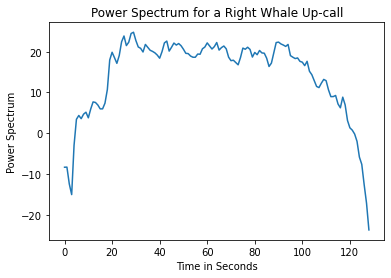

In [22]:
# plot an example of power spectrum
plt.plot(feature_dict['train/train00006.aiff'])
plt.title('Power Spectrum for a Right Whale Up-call')
plt.ylabel('Power Spectrum')
plt.xlabel('Time in Seconds')

In [23]:
whale_array.shape

(4000,)

In [24]:
y = np.load('y.npy')

In [25]:
#y = np.array(labels['label'][X.columns])
y = y.astype('float32')

In [26]:
X = pd.DataFrame(feature_dict).T

**Importing Libraries for Deep Learning on Time Domain Objects**

In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

**Training - Validation Dataset Split**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2018, shuffle=True)

X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)

**Building the Neural Network**

In [29]:
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(129, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

2022-08-13 06:46:17.724638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Jargon Translation:**

|Term| Explanation|
|---|---|
|Convolutional Layers | layers which are robust to time shifts|
|Max Pooling/ Average Pooling |dimension reduction, robustness|
|Batch normalization |equalizes the distribution of the batches |
|Epochs |1 run of a batch |
|Adam Optimizer | an adaptive optimization scheme|
|Cross Entropy | cost function|
|ReLU | nonlinear activation function| 
|Batch Size| size of subset to process to update the estimates|
|Learning Rate | time step of the optimization algorithm|

**Visualizing the Computation Graph**

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_plot.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


**Model Logging Object**

In [31]:
model_name = 'deep_1'
top_weights_path = 'model_' + str(model_name) + '.h5'

callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True), 
    EarlyStopping(monitor = 'val_accuracy', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger('model_' + str(model_name) + '.log')]

**Model Training**

In [32]:
%%time
# Fitting the Model(this will take loooooooong time, if run on CPU)
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data = [X_val, y_val], callbacks = callbacks_list)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.6596
Epoch 1: val_accuracy improved from -inf to 0.74850, saving model to model_deep_1.h5
63/63 [==============================] - 14s 191ms/step - loss: 0.6408 - accuracy: 0.6596 - val_loss: 0.6025 - val_accuracy: 0.7485 - lr: 0.0100
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.7182
Epoch 2: val_accuracy did not improve from 0.74850
63/63 [==============================] - 12s 186ms/step - loss: 0.5585 - accuracy: 0.7182 - val_loss: 0.5573 - val_accuracy: 0.7485 - lr: 0.0100
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.7671
Epoch 3: val_accuracy did not improve from 0.74850
63/63 [==============================] - 11s 182ms/step - loss: 0.4950 - accuracy: 0.7671 - val_loss: 0.5537 - val_accuracy: 0.7485 - lr: 0.0100
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.781

**Evaluation**

In [34]:
model.load_weights(top_weights_path)
loss, acc = model.evaluate(X_val, y_val, batch_size=16)
print('Validation accuracy:', acc)

125/125 [==============================] - 1s 8ms/step - loss: 0.4058 - accuracy: 0.8220
Validation accuracy: 0.8220000267028809


In [35]:
# prediction and prediction scores
y_pred = np.array((model.predict(X_val)>0.5).astype('int32'))
y_score = model.predict(X_val)

63/63 [==============================] - 1s 14ms/step


In [36]:
# precision
print('Validation precision:', sum(y_pred[y_val == 1]>0)/sum(y_pred == 1))

Validation precision: [0.66819222]


In [37]:
# recall
print('Validation recall:', sum(y_pred[y_val == 1]>0)/sum(y_val == 1))

Validation recall: [0.5805169]


Text(0.5, 14.09375, 'Predicted label')

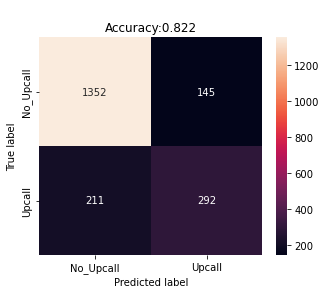

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_val,y_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['No_Upcall','Upcall'], 
                     columns = ['No_Upcall','Upcall'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('\nAccuracy:{0:.3f}'.format(accuracy_score(y_val, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

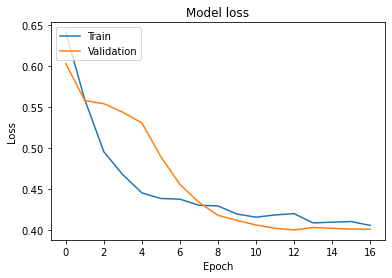

In [39]:
# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
# Prediction Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

KeyError: 'acc'

In [41]:
# Accuracy
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve 
roc_auc = roc_auc_score(y_val.astype('int'), y_score)
fpr, tpr, _ = roc_curve(y_val, y_score)

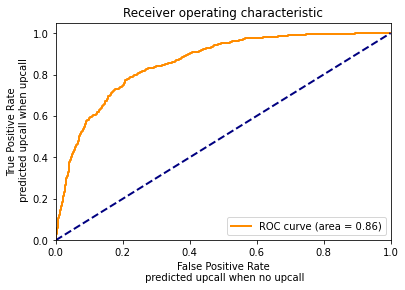

In [42]:
# Plotting Accuracy
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\n predicted upcall when no upcall')
plt.ylabel('True Positive Rate\n predicted upcall when upcall')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [43]:
# Precision Recall
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_val.astype('int'), y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.65


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.65')

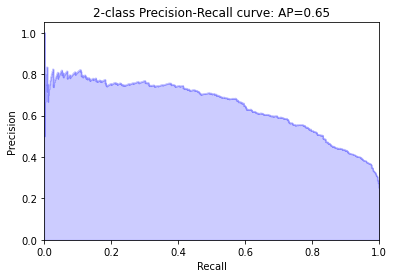

In [44]:
# Plotting Prediction and Recall
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_val.astype('int'), y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

**More:** 

* Data Augmentation: [Image Data Generators](https://keras.io/preprocessing/image/) 
* Transfer Learning: [blog](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a), [example](https://www.kaggle.com/valcoder/whalesounds-dl-2d/)
* 2D Convolutional Networks

**References:**

[Deep Learning Glossary](http://www.wildml.com/deep-learning-glossary/)

[Keras and NN Tutorial](https://indico.cern.ch/event/506145/contributions/2132944/attachments/1258124/1858154/NNinKeras_MPaganini.pdf)

[Keras Cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf)

Free GPU usage: [Google Colaboratory notebooks](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) & [Kaggle Kernels](https://www.kaggle.com/kernels).

Monitoring Performance: [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard), [TensorWatch](https://github.com/microsoft/tensorwatch/blob/master/README.md)